# Sample Functions for Analysis

In [1]:
import gensim#For word2vec, etc
from gensim.models import ldaseqmodel

import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import scipy
import matplotlib
import matplotlib.pyplot as plt #For graphics
import wordcloud
import seaborn as sns #makes our plots look nicer

from sklearn.cluster import KMeans
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

import nltk
from nltk.collocations import *

import networkx as nx
import copy

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## Preparations

In [2]:
# load data
rename_dict = {'id': 'text_id',
               'word_counts': 'word_count',
               'author': 'source',
              }

data = pd.read_csv("twitter_data_to_concat.csv").drop(columns=['Unnamed: 0']).rename(columns=rename_dict)

In [3]:
# tokenize and normalize words
data['tokenized_words'] = data['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
data['normalized_words'] = data['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))
data['normalized_words_POS'] = [lucem_illud_2020.spacy_pos(t) for t in data['text']]


# tokenize and normalize sentences
data['tokenized_sents'] = data['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
data['normalized_sents'] = data['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [4]:
data.to_pickle("data/data_normalized.pkl")

In [5]:
data = data[data['genre']=='twitter']
data.genre.unique()

array(['twitter'], dtype=object)

## Word/Phrase Frequency

In [6]:
#Frequency Distribution
fdist = nltk.FreqDist([w for w in data['normalized_words'].sum()])
freq = pd.DataFrame.from_dict(fdist, orient='index', columns=['count'])
freq = freq.sort_values(by='count', ascending=False)

In [7]:
freq[:10]

,count
refugee,45410
camp,6326
syrian,4131
amp,3715
child,3085
s,2843
help,2652
syria,2640
people,2448
new,2090


In [8]:
years = data['year'].unique()
years

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019], dtype=int64)

In [9]:
# get context

for yr in years:
    yearly = data[data['year']==yr]
    post_text = nltk.Text(yearly['tokenized_words'].sum())
    index = nltk.text.ConcordanceIndex(post_text) 
    print(yr)
    index.print_concordance('refugee', lines=10)
    index.print_concordance('refugees', lines=10)
    post_text.common_contexts(['refugees'])

2007
Displaying 10 of 850 matches:
finally after a month as corporate refugee back in our offices at one broadway
alling for the release of a ugandan refugee and her children a demonstration is
alling for the release of a ugandan refugee and her children watching a hurrica
ry before bed made me dream i was a refugee scary pakistan announces it will cl
announces it will close four afghan refugee camps in its border provinces by th
announces it will close four afghan refugee camps in its border provinces by th
ovinces by the end of august the un refugee chief says us willingness to take u
refugees is a very good step the un refugee chief says us willingness to take u
ood step jfk has been turned into a refugee camp just had my palm read by katri
morese civilian during a clash in a refugee camp in dili just opened a blog in 
Displaying 10 of 735 matches:
willingness to take up to 7000 iraq refugees is a very good step the un refugee 
willingness to take up to 7000 iraq refugees is a very 

the_who displaced_of iranian_in for_mexican jewish_were out_noborder
via_footage of_killed here_unhcr world_unhcr ihr_senjohnmccain
2010_tensions distinguished_honored should_unhcr more_coming
climate_report 33000_and coast_exceed ivorian_in help_we
2012
Displaying 10 of 1967 matches:
photo amerasian refugee the children of american servicemen
n is to draw world attention on the refugee and humanitarian crisis of idps yem
r i toh admire his acting since his refugee love2hateu two tragedies are assoc 
efugees orphans and widows overseas refugee assistance programs for africa bure
d school installing solar energy at refugee schools wout electricity she s my h
more than 90 of rapes in the dadaab refugee camps in kenya occur while women se
nd hope of a priest who visited the refugee camps in northern srilanka tamil lk
nna 59 palestinian from jordan w uk refugee status he has 5 children last one b
321 gaddafi figures applied for pol refugee status through unchr libya tunisia 
afi regime fig

of_jesus leader_have about_have tweet4upatriots_come syrian_wish
reports_contribute syrian_helped syrian_suffer refugeeswelcome_life
about_can any_from muslim_914 syrian_newly syrian_into syrian_adapt
more_more making_feel via_how with_suffering with_in
2017
Displaying 10 of 1468 matches:
the refugee crisis in australia is a hostage cr
r organizing santa visits to syrian refugee homes in montreal agbu as much as y
gbu as much as you ve done it to my refugee brothers and sisters you ve done it
the un and it will save us from the refugee flood since the un dictates who we 
he leaves office asylum door asylum refugee auspol happynewyear may 2017 be a y
gin taking patients tomorrow syrian refugee asked isis for 150000 to turn cars 
 safe zones but he s no good syrian refugee arrested for preparing bombings in 
 caught trying to smuggle a teenage refugee hidden in her suitcase into spanish
spanish territory racists we demand refugee age tests doctors not medical scien
make up 44 of the worl

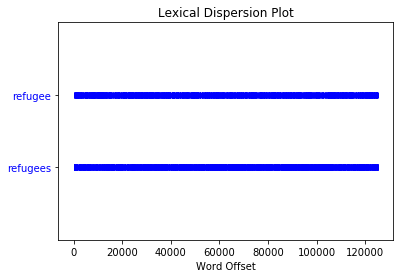

In [10]:
#Lexical Dispersion Plot
sns.reset_orig() #Seaborn messes with this plot, disabling it
post_text.dispersion_plot(['refugee', 'refugees'])
sns.set() #Re-enabling seaborn

In [11]:
#Most common POS
def get_most_common_POS(data, years, genre=None):
    for yr in years:
        if genre:
            yearly = data[(data['genre']==genre) & (data['year']==yr)]
        else:
            yearly = data[data['year']==yr]
        freqdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in yearly['normalized_words_POS'].sum())
        print(yr)
        print("Most Common Nouns")
        print(freqdist_POStoWord['NN'].most_common(10))
        print()
        print("Most Common Adj")
        print(freqdist_POStoWord['JJ'].most_common(10))
        print()
        print("Most Common Verbs")
        print(freqdist_POStoWord['VB'].most_common(10))
        print()

In [12]:
years = sorted(data['year'].unique())
genres = data['genre'].unique()
genres

array(['twitter'], dtype=object)

In [13]:
get_most_common_POS(data, years)

2007
Most Common Nouns
[('refugee', 533), ('camp', 332), ('army', 47), ('fighting', 35), ('world', 30), ('crisis', 29), ('aid', 24), ('government', 24), ('source', 24), ('return', 24)]

Most Common Adj
[('iraqi', 176), ('lebanese', 157), ('palestinian', 132), ('new', 32), ('burmese', 23), ('islamist', 21), ('sudanese', 20), ('dead', 20), ('full', 18), ('first', 18)]

Most Common Verbs
[('be', 49), ('return', 20), ('have', 13), ('take', 12), ('do', 10), ('help', 10), ('start', 9), ('rise', 9), ('get', 9), ('let', 9)]

2008
Most Common Nouns
[('refugee', 1329), ('camp', 330), ('prayer', 98), ('today', 71), ('world', 68), ('day', 61), ('aid', 59), ('news', 55), ('time', 49), ('family', 47)]

Most Common Adj
[('iraqi', 199), ('new', 97), ('palestinian', 89), ('good', 53), ('first', 41), ('many', 41), ('last', 40), ('great', 38), ('sudanese', 36), ('burmese', 35)]

Most Common Verbs
[('be', 121), ('rise', 80), ('have', 79), ('help', 65), ('go', 44), ('get', 44), ('take', 42), ('live', 30), 

In [14]:
# Word Cloud by year
for yr in years:
    yearly = data[data['year']==yr]
    words = yearly['normalized_words'].sum()
    if words==0:
        continue
    wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(words))
    wc.to_file('wordcloud/data_{}_All.png'.format(yr))
# nouns and sentiments

In [15]:
def get_nouns_and_adj(data):
    noun_adj = []
    for word, pos in data['normalized_words_POS'].sum():
        if pos.startswith('NN') or pos.startswith('JJ'):
            noun_adj.append(word)
    return noun_adj

In [16]:
for yr in years:
    yearly = data[data['year']==yr]
    words = get_nouns_and_adj(yearly)
    if len(words)==0:
        continue
    wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(words))
    wc.to_file('wordcloud/data_{}_Nouns_Adj.png'.format(yr))

In [17]:
# collocations
for yr in years:
    yearly = data[data['year']==yr]
    words = yearly['normalized_words'].sum()
    
    data_bigrams = nltk.collocations.BigramCollocationFinder.from_words(words)
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    print(yr)
    print(data_bigrams.score_ngrams(bigram_measures.likelihood_ratio)[:5])
    
    data_trigrams = nltk.collocations.TrigramCollocationFinder.from_words(words)
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    print(data_trigrams.score_ngrams(trigram_measures.likelihood_ratio)[:5])
    
# other options include student_t, chi_sq, likelihood_ratio, pmi

2007
[(('refugee', 'camp'), 1458.0396319144202), (('iraqi', 'refugee'), 583.3708060752704), (('sierra', 'leones'), 554.8557711887514), (('lebanese', 'army'), 506.32627672821747), (('palestinian', 'refugee'), 472.15534165989266)]
[(('palestinian', 'refugee', 'camp'), 2970.128025301832), (('refugee', 'camp', 'refugee'), 2498.114864319614), (('baqaa', 'refugee', 'camp'), 2421.455298551206), (('lebanon', 'refugee', 'camp'), 2299.6556401499647), (('darfur', 'refugee', 'camp'), 2296.8085854760993)]
2008
[(('refugee', 'camp'), 1545.485102777428), (('wwwnewestdiscoverycom', 'update'), 792.0585685543848), (('iraqi', 'refugee'), 716.0633928222071), (('refugee', 'refugee'), 672.2313868057447), (('xm', 'prayer'), 565.7449056494233)]
[(('refugee', 'refugee', 'camp'), 3330.014549575764), (('refugee', 'camp', 'refugee'), 2958.3190390696764), (('palestinian', 'refugee', 'camp'), 2789.8867489427266), (('like', 'refugee', 'camp'), 2573.571812102753), (('darfur', 'refugee', 'camp'), 2517.9998317859745)]


## Calculating Divergence

In [18]:
# def kl_divergence(X, Y):
#     P = X.copy()
#     Q = Y.copy()
#     P.columns = ['P']
#     Q.columns = ['Q']
#     df = Q.join(P).fillna(0)
#     p = df.iloc[:,1]
#     q = df.iloc[:,0]
#     D_kl = scipy.stats.entropy(p, q)
#     return D_kl

# def chi2_divergence(X,Y):
#     P = X.copy()
#     Q = Y.copy()
#     P.columns = ['P']
#     Q.columns = ['Q']
#     df = Q.join(P).fillna(0)
#     p = df.iloc[:,1]
#     q = df.iloc[:,0]
#     return scipy.stats.chisquare(p, q).statistic

# def Divergence(corpus1, corpus2, difference="KL"):
#     """Difference parameter can equal KL, Chi2, or Wass"""
#     freqP = nltk.FreqDist(corpus1)
#     P = pd.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
#     freqQ = nltk.FreqDist(corpus2)
#     Q = pd.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
#     if difference == "KL":
#         return kl_divergence(P, Q)
#     elif difference == "Chi2":
#         return chi2_divergence(P, Q)
#     elif difference == "KS":
#         try:
#             return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
#         except:
#             return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
#     elif difference == "Wasserstein":
#         try:
#             return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
#         except:
#             return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [19]:
# def plot_div_heatmap(corpora, fileids, diff_measure='KL'):
#     '''
#     Diff measure = KL, Chi2, KS or Wasserstein
#     '''
#     L = []
#     for p in corpora:
#         l = []
#         for q in corpora:
#             l.append(Divergence(p,q, difference = diff_measure))
#         L.append(l)
#     M = np.array(L)
#     fig = plt.figure()
#     div = pd.DataFrame(M, columns = fileids, index = fileids)
#     ax = sns.heatmap(div)
#     plt.show()

In [20]:
# TO CHECK
#corpora = data['normalized_words'][:2].sum()
# corpora = []
# for index, row in data.iterrows():
#     corpora.append(row['tokenized_words'])
#fileids = list(data['text_id'][:2])
#plot_div_heatmap(corpora, fileids,diff_measure='KL')

## Word Networks

In [21]:
# def wordCooccurrence(sentences, makeMatrix = False):
#     words = set()
#     for sent in sentences:
#         words |= set(sent)
#     wordLst = list(words)
#     wordIndices = {w: i for i, w in enumerate(wordLst)}
#     wordCoCounts = {}
#     #consider a sparse matrix if memory becomes an issue
#     coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
#     for sent in sentences:
#         for i, word1 in enumerate(sent):
#             word1Index = wordIndices[word1]
#             for word2 in sent[i + 1:]:
#                 coOcMat[word1Index][wordIndices[word2]] += 1
#     if makeMatrix:
#         return coOcMat, wordLst
#     else:
#         coOcMat = coOcMat.T + coOcMat
#         g = nx.convert_matrix.from_numpy_matrix(coOcMat)
#         g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
#         return g

# def connected_component_subgraphs(G):
#     for c in nx.connected_components(G):
#         yield G.subgraph(c)

# def posCooccurrence(sentences, *posType, makeMatrix = False):
#     words = set()
#     reducedSents = []
#     #Only using the first kind of POS for each word
#     wordsMap = {}
#     for sent in sentences:
#         s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
#         for w, t in s:
#             if w not in wordsMap:
#                 wordsMap[w] = t
#         reducedSent = [w for w, t in s]
#         words |= set(reducedSent)
#         reducedSents.append(reducedSent)
#     wordLst = list(words)
#     wordIndices = {w: i for i, w in enumerate(wordLst)}
#     wordCoCounts = {}
#     #consider a sparse matrix if memory becomes an issue
#     coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
#     for sent in reducedSents:
#         for i, word1 in enumerate(sent):
#             word1Index = wordIndices[word1]
#             for word2 in sent[i + 1:]:
#                 coOcMat[word1Index][wordIndices[word2]] += 1
#     if makeMatrix:
#         return coOcMat, wordLst
#     else:
#         coOcMat = coOcMat.T + coOcMat
#         g = nx.convert_matrix.from_numpy_matrix(coOcMat)
#         g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
#         for w in g.nodes:
#             g.nodes[w]['bipartite'] = wordsMap[w]
#         return g

# def plot_word_graph(graph):
#     layout = nx.spring_layout(graph, weight='weight', iterations= 100)
#     fig, ax = plt.subplots(figsize = (10,10))
#     nx.draw(graph, ax = ax, pos = layout, labels = {n:n for n in graph.nodes()},
#             width=.2, 
#             alpha = .9, 
#             node_size = 100,
#             node_color = "xkcd:light red",
#             edge_color='xkcd:black')

# def plot_word_centrality(g):
#     layout_nn = nx.spring_layout(g, weight='weight', iterations= 100)
#     fig, ax = plt.subplots(figsize = (10,10))
#     centralities_nn = nx.eigenvector_centrality(g)
#     maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
#     #maxWeight = max((d['weight'] for n1, n2, d in g.edges(data = True)))
#     #minWeight = min((d['weight'] for n1, n2, d in g.edges(data = True)))
#     nx.draw(g, ax = ax, pos = layout_nn, labels = {n: n for n in g.nodes()},
#             #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
#             alpha = .9, 
#             node_color = [centralities_nn[n] / maxC for n in g.nodes],
#             node_size = [centralities_nn[n] / maxC * 100 for n in g.nodes],
#             font_size = 16,
#             font_color = 'xkcd:dark grey',
#             edge_color = 'xkcd:medium blue',
#             cmap = plt.get_cmap('plasma'),
#            )

### plot word network

In [22]:
# plot word network
#g = wordCooccurrence(data['normalized_sents'].sum())
#len(g)

In [23]:
# weight_choice = 25
# # remove if less than 25
# g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= weight_choice])
# #since we are changing the graph list() evaluates the isolates first
# g.remove_nodes_from(list(nx.isolates(g)))
# # keep just the giant connected component
# main_graph = max(connected_component_subgraphs(g), key=len)
# print(nx.info(main_graph))

In [24]:
# plot_word_graph(main_graph)

In [25]:
# # plot sub-graph
# immigrant_neighbors = main_graph.neighbors('family')
# subgraph_immigrant = main_graph.subgraph(immigrant_neighbors)
# print(nx.info(subgraph_immigrant))

# plot_word_graph(subgraph_immigrant)

In [26]:
# # cliques
# print(', '.join(max(nx.clique.find_cliques(main_graph), key = lambda x: len(x))))

### plot word network by pos

In [27]:
# # plot pos network
# gNV = posCooccurrence(data['normalized_sents'].sum(), 'NN', 'VB')
# print(nx.info(gNV))

In [28]:
# degree_threshold= 100
# weight_threshold = 2
# gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= degree_threshold]) 
# print(nx.info(gNV))
# gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= weight_threshold])
# print(nx.info(gNV))

In [29]:
# #TO CHECK
# plot_word_centrality(gNV)

In [30]:
# # draw egocentric network
# g_immigrant_NV = gNV.subgraph(['family'] + list(gNV.neighbors('family')))
# print(nx.info(g_immigrant_NV))

In [31]:
# nx.draw_networkx(g_immigrant_NV)

### centrality & global measures

In [32]:
# #centralities

# centralities = nx.degree_centrality(main_graph)
# #centralities = nx.eigenvector_centrality(main_graph)
# #centralities = nx.closeness_centrality(main_graph)
# #centralities = nx.betweenness.betweenness_centrality(main_graph)
# plt.hist(list(centralities.values()))
# plt.show()

In [33]:
# name = 'degree'

# centrality_df = pd.DataFrame.from_dict(centralities, orient='index', columns=[name])
# centrality_df.sort_values(by=name, ascending=False, inplace=True)
# #highest 10
# centrality_df[:10]

In [34]:
# #global measures
# density = nx.density(main_graph)
# mean_degree_pernode = np.mean([v for w,v in nx.degree(main_graph)])
# diameter = nx.diameter(main_graph)
# print(
# "The density of this graph is {}\n\
# Mean degree per node is {}\n\
# Diameter of graph is {}".format(density, mean_degree_pernode, diameter))

## Clustering

In [35]:
# TFIDF vectoriser
data_vectoriser = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
dataVects = data_vectoriser.fit_transform(data['text'])

For 2 clusters, average silhouette score is 0.011106502897106798
For 3 clusters, average silhouette score is 0.009621884140789145
For 4 clusters, average silhouette score is 0.009660120004753242
For 5 clusters, average silhouette score is 0.010445734032369544
For 6 clusters, average silhouette score is 0.010958634454054988
For 7 clusters, average silhouette score is 0.01272348467505349
For 8 clusters, average silhouette score is 0.014550098274924874
For 9 clusters, average silhouette score is 0.015048085257045807


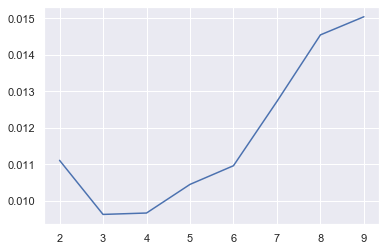

In [36]:
def find_best_n(X, max=10):
    clusters = []
    s_avg = []
    for i in range(2, max):
        clusterer = sklearn.cluster.KMeans(n_clusters=i, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
        clusters.append(i)
        s_avg.append(silhouette_avg)
        print("For {} clusters, average silhouette score is {}".format(i, silhouette_avg))
    plt.plot(clusters, s_avg)
    plt.show()

X = dataVects.toarray()
find_best_n(X)

In [37]:
num_cluster = 8
km = sklearn.cluster.KMeans(n_clusters=num_cluster, init='k-means++')
km.fit(dataVects)
data['kmeans_prediction'] = km.labels_

In [38]:
def get_top_words(km, num_cluster, data_vectoriser):
    terms = data_vectoriser.get_feature_names()
    print("Top terms per cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(num_cluster):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :20]:
            print(' %s' % terms[ind])
        print('\n')

get_top_words(km, num_cluster, data_vectoriser)

Top terms per cluster:
Cluster 0:
 asylum
 seekers
 refugees
 refugee
 seeking
 auspol
 seeker
 australia
 amp
 people
 seek
 right
 new
 boat
 human
 policy
 nauru
 detention
 status
 country


Cluster 1:
 lebanon
 syrian
 camp
 refugees
 refugee
 palestinian
 syria
 jordan
 children
 camps
 turkey
 lebanese
 army
 militants
 fighting
 return
 beirut
 amp
 afp
 blog


Cluster 2:
 refugee
 crisis
 children
 day
 new
 world
 like
 rt
 status
 just
 agency
 story
 help
 family
 today
 says
 life
 canada
 immigration
 people


Cluster 3:
 amp
 refugees
 refugee
 children
 women
 help
 syria
 people
 syrian
 new
 support
 today
 rt
 crisis
 migrants
 rights
 need
 displaced
 manus
 work


Cluster 4:
 syrian
 refugees
 refugee
 jordan
 syria
 turkey
 children
 help
 million
 family
 crisis
 camp
 new
 turkish
 canada
 home
 trump
 border
 says
 video


Cluster 5:
 refugees
 syria
 people
 help
 new
 unhcr
 iraqi
 million
 world
 home
 rt
 just
 country
 iraq
 like
 aid
 trump
 fleeing
 need

In [39]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components = 2).fit(dataVects.toarray())
    reduced_data = pca.transform(dataVects.toarray())
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)
    
    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")    
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


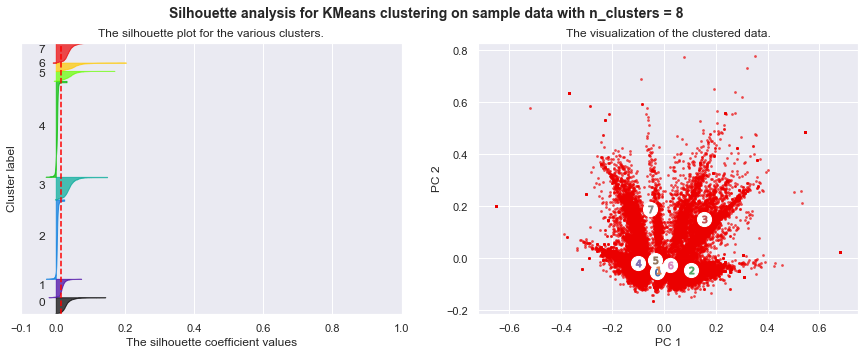

For n_clusters = 8, The average silhouette_score is : 0.015


In [40]:
plotSilhouette(num_cluster, X)

In [41]:
def plot_clusters(dataVects, km, num_cluster, terms=data_vectoriser.get_feature_names()):
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components = 2).fit(dataVects.toarray())
    reduced_data = pca.transform(dataVects.toarray())
    # get distinguishing words to label
    components = pca.components_
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
    words = [terms[i] for i in keyword_ids]#Turn the ids into words.
    x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
    y = components[:,keyword_ids][1,:]
    
    cmap = matplotlib.cm.get_cmap("viridis")
    colors_p = [cmap(l/num_cluster) for l in km.labels_]
    
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha = 0.5)
    for i, word in enumerate(words):
        ax.annotate(word, (x[i],y[i]))
    plt.xticks(())
    plt.yticks(())
    plt.title('Predicted Clusters\n k = {}'.format(num_cluster))
    plt.show()

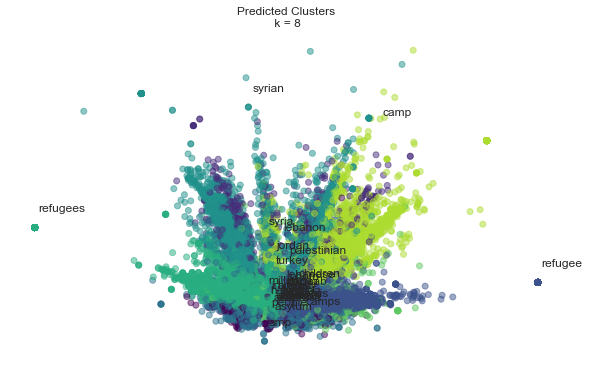

In [42]:
plot_clusters(dataVects, km, num_cluster)

## Topic Modelling

In [43]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

data['reduced_tokens'] = data['normalized_words'].apply(lambda x: dropMissing(x, data_vectoriser.vocabulary_.keys()))

In [44]:
# creating dictionary
dictionary = gensim.corpora.Dictionary(data['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in data['reduced_tokens']]
# serialize
gensim.corpora.MmCorpus.serialize('data.mm', corpus)
data_mm = gensim.corpora.MmCorpus('data.mm')
# topic modelling
topics=10
data_lda = gensim.models.ldamodel.LdaModel(corpus=data_mm, id2word=dictionary, num_topics=topics, alpha='auto', eta='auto')

In [45]:
data_lda.save("data_lda")

In [46]:
def plot_topics(data_lda, dictionary, data, title, n=10):
    data_ldaDF = create_lda_df(data_lda, dictionary, data)
    data_ldaDFV = data_ldaDF[:n][['topic_%d' %x for x in range(data_lda.num_topics)]]
    data_ldaDFVisN = data_ldaDF[:n][['text_id']]
    data_ldaDFVis = data_ldaDFV.values
    data_ldaDFVisNames = data_ldaDFVisN.values
    plot_topics_barchart(data_lda, data_ldaDFVis, data_ldaDFVisNames, title, n)
    return data_ldaDF

def create_lda_df(data_lda, dictionary, data):
    # create a df of text and topics
    data_ldaDF = pd.DataFrame({
                'text_id' : data['text_id'],
                'title': data['title'],
                'year': data['year'],
                'topics' : [data_lda[dictionary.doc2bow(l)] for l in data['reduced_tokens']]
        })

    #Dict to temporally hold the probabilities
    topicsProbDict = {i : [0] * len(data_ldaDF) for i in range(data_lda.num_topics)}

    #Load them into the dict
    for index, topicTuples in enumerate(data_ldaDF['topics']):
        for topicNum, prob in topicTuples:
            topicsProbDict[topicNum][index] = prob

    #Update the DataFrame
    for topicNum in range(data_lda.num_topics):
        data_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
    return data_ldaDF


def plot_topics_barchart(senlda, ldaDFVis, ldaDFVisNames, title, N):
    ind = np.arange(N)
    K = senlda.num_topics  # N documents, K topics
    ind = np.arange(N)  # the x-axis locations for the novels
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(N)

    for k in range(K):
        color = plt.cm.coolwarm(k/K, 1)
        if k == 0:
            p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
        else:
            p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += ldaDFVis[:, k]
        plots.append(p)


    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel('Topics')

    plt.title(title)
    plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

    plt.yticks(np.arange(0, 1, 10))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

    plt.show()

In [48]:
n=20
title = "topics relevant to immigra in first {} documents".format(n)
plot_topics(data_lda, dictionary, data, title, n=n)

KeyError: 'title'

In [49]:
for i in range(data_lda.num_topics):
    print(i)
    print(data_lda.show_topic(i, topn=10))

0
[('refugee', 0.12860587), ('right', 0.082258396), ('child', 0.05335679), ('welcome', 0.04711787), ('rohingya', 0.038535573), ('human', 0.037529007), ('law', 0.023638984), ('australia', 0.021790765), ('detention', 0.020291874), ('way', 0.019938592)]
1
[('refugee', 0.11692706), ('woman', 0.038637158), ('amp', 0.037411675), ('live', 0.030835032), ('migrant', 0.023663847), ('try', 0.022002865), ('administration', 0.018565658), ('come', 0.018474093), ('want', 0.01772395), ('obama', 0.016744195)]
2
[('refugee', 0.11486542), ('amp', 0.08176268), ('immigrant', 0.046268336), ('thank', 0.02336259), ('government', 0.023223454), ('child', 0.02192797), ('girl', 0.020738611), ('crisis', 0.017797453), ('old', 0.016812477), ('community', 0.015750261)]
3
[('refugee', 0.16165148), ('syrian', 0.1143346), ('trump', 0.045193676), ('camp', 0.041562267), ('syria', 0.024301792), ('safe', 0.021760123), ('president', 0.020958297), ('create', 0.017379545), ('palestinian', 0.017197626), ('time', 0.015841993)]
4

In [50]:
#dynamic topic modelling - long run time (overnight)
docs_per_year = list(data.groupby('year').size())
num_topics = 4
data_ldaseq = ldaseqmodel.LdaSeqModel(corpus=data_mm, id2word=dictionary, time_slice=docs_per_year, num_topics=num_topics)

C:\Users\John Xu\AppData\Roaming\Python\Python36\site-packages\gensim\models\ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
C:\Users\John Xu\AppData\Roaming\Python\Python36\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
C:\Users\John Xu\AppData\Roaming\Python\Python36\site-packages\gensim\models\ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
C:\Users\John Xu\AppData\Roaming\Python\Python36\site-packages\gensim\models\ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
C:\Users\John Xu\AppData\Roaming\Python\Python36\site-packages\gensim\models\ldaseqmodel.py:1474: RuntimeWarning: in

In [51]:
data_ldaseq.save("data_ldaseq")

In [52]:
data_ldaseq.print_topics(time=0)

[[('refugee', 0.20137650549562966),
  ('right', 0.022207038208875693),
  ('asylum', 0.013056392442584417),
  ('status', 0.012799392937738144),
  ('rise', 0.011419974425846814),
  ('canada', 0.010358459987562211),
  ('israel', 0.010329779109055222),
  ('say', 0.010160413872870743),
  ('human', 0.009241874453911562),
  ('prayer', 0.00899874332569191),
  ('african', 0.00805629263396032),
  ('boat', 0.007682140925877626),
  ('immigration', 0.007617445173240443),
  ('seek', 0.007408951152890105),
  ('country', 0.007370440113870304),
  ('libya', 0.007271728038764071),
  ('claim', 0.0068634434883278),
  ('stop', 0.00675236562181338),
  ('seeker', 0.006537244065093978),
  ('people', 0.006167387263999764)],
 [('refugee', 0.18461831530288428),
  ('camp', 0.11009149056897072),
  ('iraqi', 0.0448177307667581),
  ('lebanon', 0.040193443992683986),
  ('palestinian', 0.03339962034868308),
  ('lebanese', 0.015202335669450935),
  ('child', 0.011738213300330107),
  ('syria', 0.010671564150790812),
  ('k

In [53]:
#topic distribution divergence
from gensim.matutils import kullback_leibler

def plot_topic_divergence(data, years, num_topics=5):
    topic_prob, lda = get_topic_prob(data, years, num_topics)
    L = []
    for year_1 in topic_prob.keys():
        p = topic_prob[year_1]
        l = []
        for year_2 in topic_prob.keys():
            q = topic_prob[year_2]
            l.append(kullback_leibler(p, q))
        L.append(l)
    M = np.array(L)

    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(topic_prob.keys()), index = list(topic_prob.keys()))
    ax = sns.heatmap(div)
    plt.show()
    return lda
    
def get_topic_prob(data, years, num_topics=5):
    topic_prob = {}
    
    byyear, lda = get_topic_distribution(data, years, num_topics)
    # Convert to probability
    for yr in years:
        j=0
        for i in range(10):
            try:
                index, prob = byyear[yr][j]
            except IndexError:
                index = False

            if index == i:
                j+=1
                if yr in topic_prob:  
                    topic_prob[yr].append(prob)
                else:
                    topic_prob[yr] = [prob]
            else:
                if yr in topic_prob:  
                    topic_prob[yr].append(float(0))
                else:
                    topic_prob[yr] = [float(0)]
    return topic_prob, lda


def get_topic_distribution(data, years, num_topics=5):
    byyear = {}
    lda = {}
    # Get topic distribution for each year
    for yr in years:
        # get all text for each year
        text_df = data[data['year']==yr][['text']]
        text_df['tokenized_text'] = text_df['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
        text_df['normalized_tokens'] = text_df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))
        # create dictionary
        data_dictionary_byyear = gensim.corpora.Dictionary(text_df['normalized_tokens'])
        data_corpus_byyear = [data_dictionary_byyear.doc2bow(text) for text in text_df['normalized_tokens']]
        #lda
        lda_byyear = gensim.models.ldamodel.LdaModel(corpus=data_corpus_byyear, id2word=data_dictionary_byyear, num_topics=num_topics, alpha='auto', eta='auto')

        # place topic distribution in dictionary
        all_text = []
        for text in text_df['normalized_tokens']:
            all_text.extend(text)
        byyear[yr] = lda_byyear[data_dictionary_byyear.doc2bow(all_text)]
        lda[yr] = lda_byyear

        print('{} done'.format(yr))
    return byyear, lda

2007 done
2008 done
2009 done
2010 done
2011 done
2012 done
2013 done
2014 done
2015 done
2016 done
2017 done
2018 done
2019 done


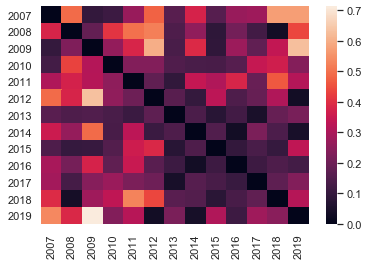

In [54]:
years = sorted(data['year'].unique())
lda_by_year = plot_topic_divergence(data, years, num_topics=5)
# think about how to use this for dynamic modelling

In [55]:
for yr in years:
    for i in range(5):
        print("Year: {}, Topic: {}".format(yr, i))
        print(lda_by_year[yr].show_topic(i, topn=10))

Year: 2007, Topic: 0
[('refugee', 0.083727404), ('lebanon', 0.022132998), ('camp', 0.01872151), ('palestinian', 0.011172055), ('iraqi', 0.007300757), ('not', 0.006676916), ('un', 0.006087229), ('press', 0.005855918), ('return', 0.0054183747), ('blog', 0.005319814)]
Year: 2007, Topic: 1
[('refugee', 0.08742062), ('camp', 0.029384041), ('lebanon', 0.014282699), ('militant', 0.010524722), ('lebanese', 0.008509338), ('iraqi', 0.007883505), ('news', 0.007398168), ('army', 0.0065418533), ('iraq', 0.005948251), ('return', 0.0059050913)]
Year: 2007, Topic: 2
[('refugee', 0.091966346), ('camp', 0.028437683), ('iraqi', 0.018077938), ('lebanon', 0.017433101), ('lebanese', 0.015303807), ('fight', 0.008459454), ('home', 0.0067004794), ('army', 0.006332581), ('return', 0.0061257365), ('troop', 0.0052899676)]
Year: 2007, Topic: 3
[('refugee', 0.07902604), ('iraqi', 0.015411722), ('iraq', 0.01113701), ('camp', 0.009715842), ('un', 0.006899492), ('palestinian', 0.0051999507), ('nation', 0.0051780357), 

## Word Embeddings

### word2vec

In [56]:
data_w2v = gensim.models.word2vec.Word2Vec(data['normalized_sents'].sum())

In [57]:
data_w2v.save('data_w2v')

In [58]:
data_w2v = gensim.models.word2vec.Word2Vec.load('data_w2v')

In [59]:
data_w2v.most_similar(positive=['refugee'])
#&amp, rt

[('imminent', 0.6740483045578003),
 ('refugeeasylum', 0.6711429357528687),
 ('concentration', 0.6391953825950623),
 ('hv', 0.6344782114028931),
 ('traumatise', 0.6236859560012817),
 ('newroz', 0.6203596591949463),
 ('elder', 0.6181735992431641),
 ('alarabiya_eng', 0.6178646087646484),
 ('pauktaw', 0.6178143620491028),
 ('jalozai', 0.6161245107650757)]

In [60]:
data_w2v.most_similar(positive=['asylumseekers'])

[('economic', 0.9875187277793884),
 ('deter', 0.9815937280654907),
 ('gay', 0.9811919927597046),
 ('backthebill', 0.9796459674835205),
 ('faysal', 0.979388415813446),
 ('systemic', 0.9785310626029968),
 ('hearing', 0.977130651473999),
 ('entry', 0.9770314693450928),
 ('dehumanise', 0.9765188694000244),
 ('genuine', 0.9759035110473633)]

In [61]:
data_w2v.similarity('refugee','asylumseekers')

0.48602718

In [62]:
data_w2v.most_similar(positive=['refugee', 'illegal'], negative=['legal'])

[('concentration', 0.750876784324646),
 ('imminent', 0.7042614221572876),
 ('koreans', 0.6999655961990356),
 ('traumatise', 0.6981511116027832),
 ('hv', 0.6979647874832153),
 ('ynetnews', 0.6900030374526978),
 ('parent', 0.6846592426300049),
 ('ancestor', 0.6837400197982788),
 ('tripura', 0.6837168335914612),
 ('refugeeasylum', 0.6834601163864136)]

In [63]:
data_w2v.most_similar(positive=['refugee', 'independent'], negative=['dependent'])

[('refugeeasylum', 0.7055233716964722),
 ('imminent', 0.6713334321975708),
 ('automatic', 0.6705769300460815),
 ('specifically', 0.6671869158744812),
 ('cancellation', 0.6651816368103027),
 ('ultimatum', 0.6604119539260864),
 ('hv', 0.6501164436340332),
 ('ynetnews', 0.6497980952262878),
 ('thailands', 0.6466238498687744),
 ('bari', 0.6441673636436462)]

In [64]:
data_w2v.similarity('refugee','help')

0.31709105

In [65]:
data_w2v.similarity('refugee','crisis')

0.108937174

In [66]:
def plot_embeddings(data_w2v, numWords, save=False, title=''):
    targetWords = data_w2v.wv.index2word[:numWords]
    wordsSubMatrix = []
    for word in targetWords:
        wordsSubMatrix.append(data_w2v[word])
    wordsSubMatrix = np.array(wordsSubMatrix)
    pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
    reducedPCA_data = pcaWords.transform(wordsSubMatrix)
    #T-SNE is theoretically better, but you should experiment
    tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
    for i, word in enumerate(targetWords):
        ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    if save:
        fig.savefig("embeddingplot/{}".format(title), format='png')

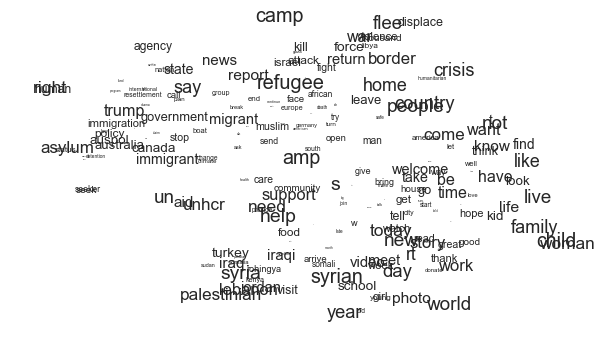

In [67]:
plot_embeddings(data_w2v, 200)

In [68]:
years=sorted(data['year'].unique())

2007
[('camp', 0.9998911619186401), ('palestinian', 0.9997987151145935), ('iraqi', 0.9997807741165161), ('lebanon', 0.9997803568840027), ('army', 0.9997537136077881), ('lebanese', 0.999748945236206), ('darfur', 0.9997300505638123), ('say', 0.9997147917747498), ('un', 0.9997134208679199), ('news', 0.9997066259384155)]


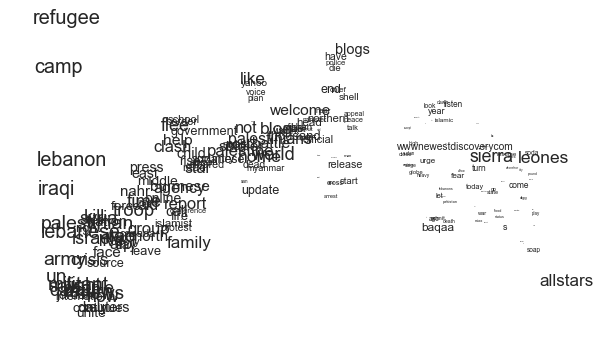

2008
[('camp', 0.9999553561210632), ('help', 0.9999344348907471), ('year', 0.9999260902404785), ('woman', 0.9999257922172546), ('palestinian', 0.9999229907989502), ('people', 0.9999219179153442), ('time', 0.9999194741249084), ('new', 0.9999170899391174), ('story', 0.9999169707298279), ('need', 0.9999138712882996)]


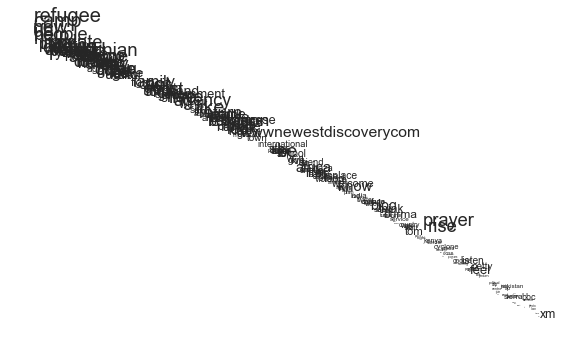

2009
[('help', 0.9999468922615051), ('camp', 0.9999445080757141), ('news', 0.9999430775642395), ('rt', 0.9999400973320007), ('story', 0.999939501285553), ('time', 0.9999336004257202), ('meet', 0.9999289512634277), ('group', 0.9999282360076904), ('need', 0.9999270439147949), ('work', 0.9999269247055054)]


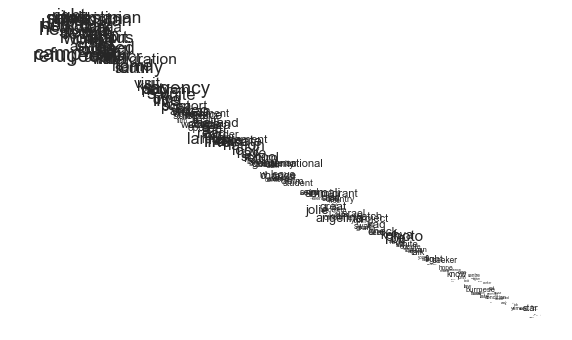

2010
[('camp', 0.9999526739120483), ('help', 0.9999462366104126), ('story', 0.9999414682388306), ('unhcr', 0.9999403953552246), ('new', 0.9999358057975769), ('rt', 0.9999356269836426), ('come', 0.9999351501464844), ('child', 0.999934196472168), ('amp', 0.9999329447746277), ('work', 0.9999317526817322)]


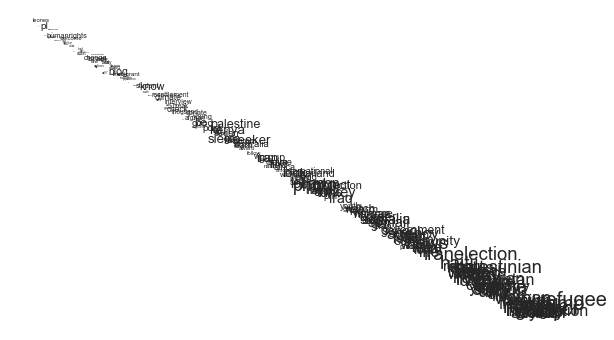

2011
[('amp', 0.9999417662620544), ('story', 0.9999348521232605), ('year', 0.999932587146759), ('unhcr', 0.9999302625656128), ('help', 0.9999289512634277), ('w', 0.9999279975891113), ('camp', 0.999927282333374), ('child', 0.9999268054962158), ('aid', 0.9999266862869263), ('not', 0.9999263286590576)]


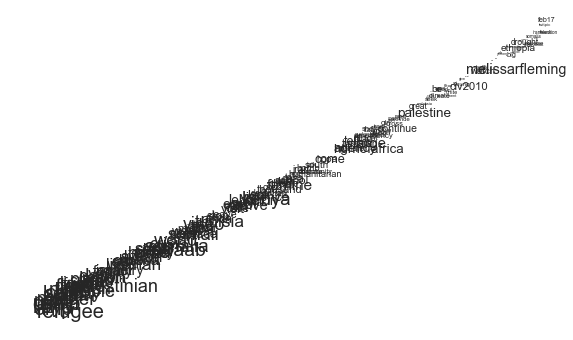

2012
[('amp', 0.9999465346336365), ('camp', 0.999944269657135), ('new', 0.9999402165412903), ('people', 0.9999385476112366), ('help', 0.9999358057975769), ('syrian', 0.9999342560768127), ('story', 0.999934196472168), ('flee', 0.9999337792396545), ('child', 0.999928891658783), ('unhcr', 0.9999279975891113)]


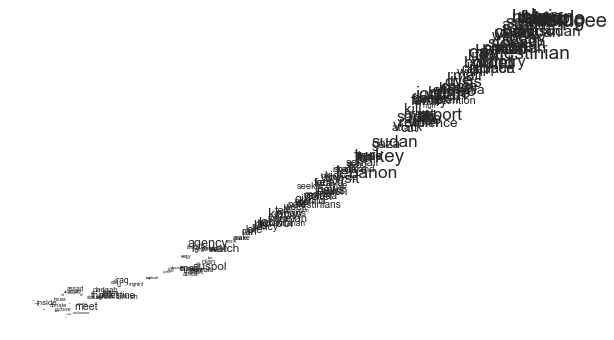

2013
[('help', 0.9999287724494934), ('camp', 0.9999239444732666), ('life', 0.9999125599861145), ('palestinian', 0.9999116659164429), ('child', 0.9999116063117981), ('year', 0.9999114274978638), ('state', 0.9999111294746399), ('time', 0.9999102354049683), ('syrian', 0.9999102354049683), ('host', 0.9999090433120728)]


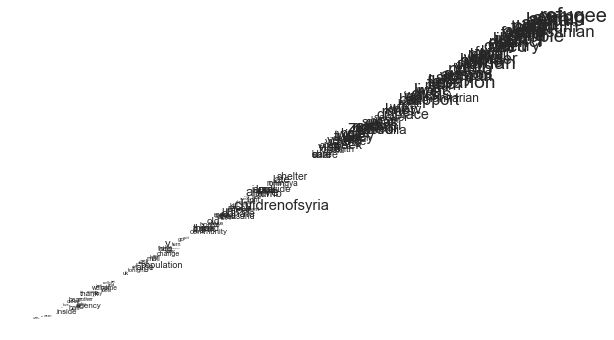

2014
[('camp', 0.9999442100524902), ('help', 0.999937891960144), ('amp', 0.9999376535415649), ('kid', 0.9999369382858276), ('syrian', 0.9999362826347351), ('child', 0.9999304413795471), ('need', 0.9999294281005859), ('flee', 0.9999293088912964), ('today', 0.9999271035194397), ('have', 0.9999263286590576)]


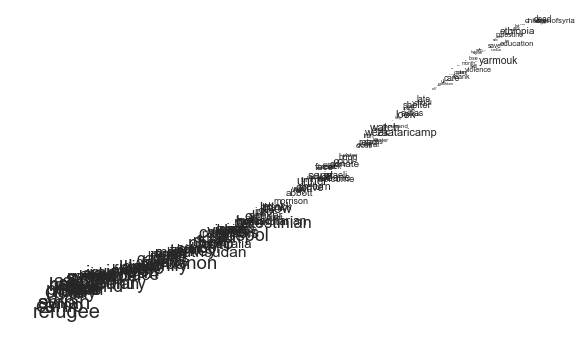

2015
[('camp', 0.9999468922615051), ('amp', 0.9999439120292664), ('syrian', 0.9999411106109619), ('help', 0.9999374747276306), ('people', 0.999936044216156), ('child', 0.9999344944953918), ('arrive', 0.9999344348907471), ('flee', 0.9999325275421143), ('come', 0.9999325275421143), ('isis', 0.9999325275421143)]


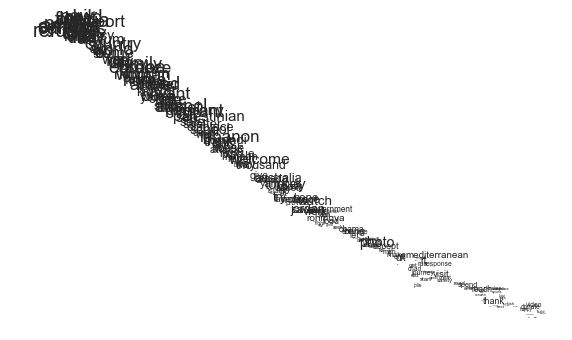

2016
[('help', 0.9999451637268066), ('camp', 0.9999420642852783), ('amp', 0.9999412298202515), ('state', 0.9999402761459351), ('year', 0.9999390244483948), ('not', 0.9999388456344604), ('need', 0.999938428401947), ('crisis', 0.9999381303787231), ('time', 0.9999380111694336), ('child', 0.9999362230300903)]


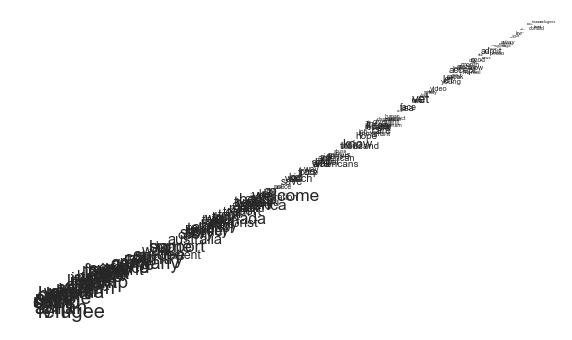

2017
[('amp', 0.9999475479125977), ('people', 0.9999440908432007), ('year', 0.9999421238899231), ('camp', 0.9999406337738037), ('story', 0.999937891960144), ('work', 0.9999375343322754), ('not', 0.9999358654022217), ('s', 0.9999355673789978), ('come', 0.9999340176582336), ('help', 0.9999333620071411)]


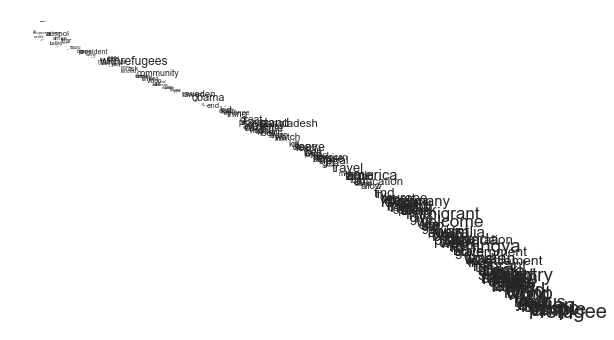

2018
[('nation', 0.9999206066131592), ('support', 0.999916672706604), ('attack', 0.999916136264801), ('time', 0.999914824962616), ('need', 0.9999140501022339), ('call', 0.9999130368232727), ('go', 0.9999125003814697), ('child', 0.999911904335022), ('immigrant', 0.9999103546142578), ('amp', 0.9999102354049683)]


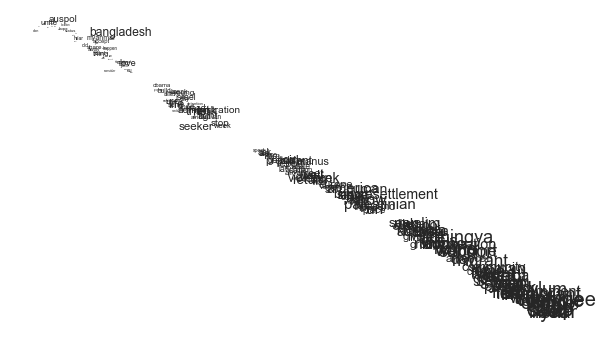

2019
[('life', 0.9999135732650757), ('nation', 0.9999119639396667), ('government', 0.9999098777770996), ('work', 0.999909520149231), ('need', 0.9999079704284668), ('s', 0.9999076128005981), ('go', 0.9999063014984131), ('american', 0.9999042749404907), ('time', 0.999904215335846), ('amp', 0.9999039769172668)]


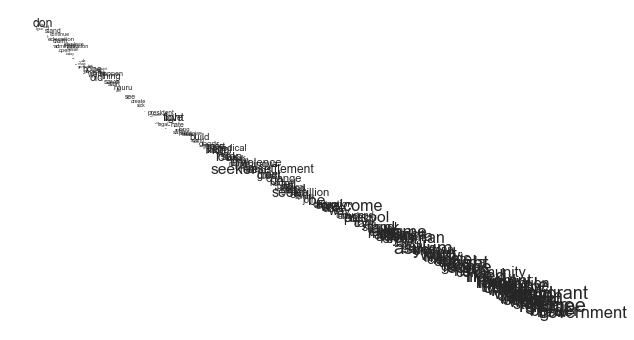

In [69]:
# Year on year
yearly_w2v = {}
for yr in years:
    yearly = data[data['year']==yr]
    data_w2v = gensim.models.word2vec.Word2Vec(yearly['normalized_sents'].sum())
    yearly_w2v[yr] = data_w2v
    print(yr)
    print(data_w2v.most_similar(positive=['refugee']))
    plot_embeddings(data_w2v, 200, save=True, title='{}.png'.format(yr))

In [70]:
yearly_w2v

{2007: <gensim.models.word2vec.Word2Vec at 0x1d94c3f4da0>,
 2008: <gensim.models.word2vec.Word2Vec at 0x1d94c3f4f28>,
 2009: <gensim.models.word2vec.Word2Vec at 0x1d94a9c46a0>,
 2010: <gensim.models.word2vec.Word2Vec at 0x1d94a9c45f8>,
 2011: <gensim.models.word2vec.Word2Vec at 0x1d94c3f4fd0>,
 2012: <gensim.models.word2vec.Word2Vec at 0x1d94a983748>,
 2013: <gensim.models.word2vec.Word2Vec at 0x1d94b10fef0>,
 2014: <gensim.models.word2vec.Word2Vec at 0x1d94b121860>,
 2015: <gensim.models.word2vec.Word2Vec at 0x1d94930db00>,
 2016: <gensim.models.word2vec.Word2Vec at 0x1d94a9355f8>,
 2017: <gensim.models.word2vec.Word2Vec at 0x1d94b11cc50>,
 2018: <gensim.models.word2vec.Word2Vec at 0x1d94a92c128>,
 2019: <gensim.models.word2vec.Word2Vec at 0x1d94aa0c5c0>}

### doc2vec

In [71]:
# def tag_docs(data):
#     taggedDocs = []
#     for index, row in data.iterrows():
#         #Just doing a simple keyword assignment
#         docKeywords = [row['year']]
#         docKeywords.append(row['text_id'])
#         docKeywords.append(row['genre'])
#         docKeywords.append(row['word_count'])
#         taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
#     return taggedDocs

# data['tagged_docs'] = tag_docs(data)

In [72]:
# memory error
#data_d2v = gensim.models.doc2vec.Doc2Vec(data['tagged_docs'],vector_size=100)

In [73]:
# data_d2v.save("data_d2v")

In [74]:
# data_d2v.most_similar(positive = ['immigrants','illegal'], negative = ['legal'], topn = 10)

In [75]:
# def most_similar_by_year(data_d2v,years):
#     for yr in years:
#         print(yr)
#         print(data_d2v.most_similar( [ data_d2v.docvecs[yr] ], topn=5))
#         print()

# years = range(1990,2016)        
# most_similar_by_year(data_d2v, years)

In [76]:
# genre = list(data['genre'].unique())       
# most_similar_by_year(data_d2v, genre)

In [77]:
# def plot_similarity(data_d2v, targetDocs):
#     heatmapMatrixD = []
#     for tagOuter in targetDocs:
#         column = []
#         tagVec = data_d2v.docvecs[tagOuter].reshape(1, -1)
#         for tagInner in targetDocs:
#             column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, data_d2v.docvecs[tagInner].reshape(1, -1))[0][0])
#         heatmapMatrixD.append(column)
#     heatmapMatrixD = np.array(heatmapMatrixD)
#     fig, ax = plt.subplots()
#     hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
#     cbar = plt.colorbar(hmap)

#     cbar.set_label('cosine similarity', rotation=270)
#     a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
#     a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

#     a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
#     a = ax.set_yticklabels(targetDocs, minor=False)

In [78]:
# plot_similarity(data_d2v, list(data['year'].unique()))

In [79]:
# plot_similarity(data_d2v, list(data['genre'].unique()))

### change over time

In [80]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [81]:
data_rawEmbeddings, data_comparedEmbeddings = compareModels(data, 'year')

In [82]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pd.DataFrame(dists, index = cats)

def plot_divergence(targetWord, comparedEmbeddings):
    pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
    fig, ax = plt.subplots(figsize = (10, 7))
    sns.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
    ax.set_xlabel("Starting year")
    ax.set_ylabel("Final year")
    ax.set_ylabel("Final year")
    ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
    plt.show()

refugee


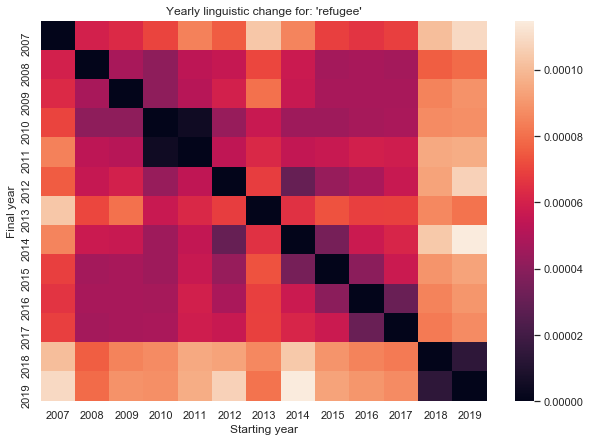

In [83]:
plot_divergence('refugee', data_comparedEmbeddings)

border


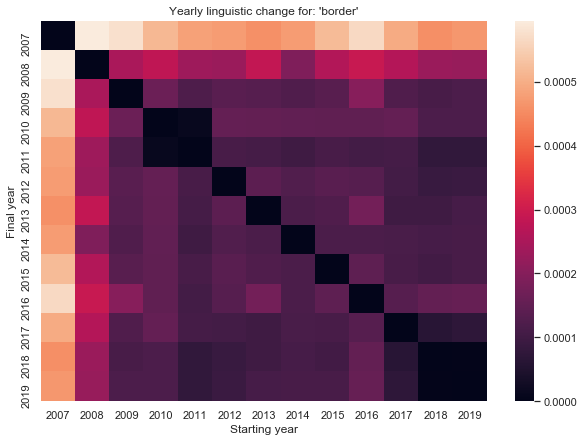

In [84]:
plot_divergence('border', data_comparedEmbeddings)

crisis


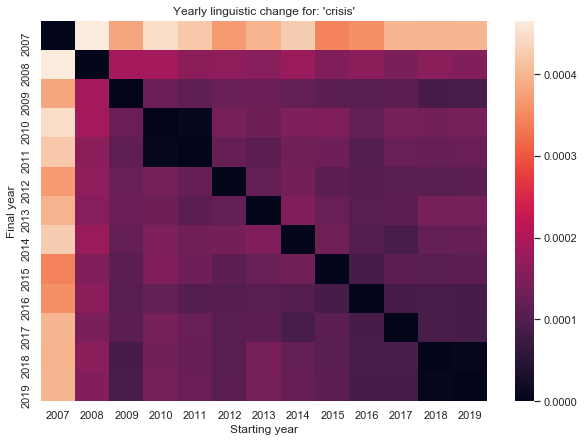

In [85]:
plot_divergence('crisis', data_comparedEmbeddings)

In [86]:
def findDivergence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDivergence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)

data_wordDivergences = findMostDivergent(data_comparedEmbeddings)

Found 276 words to compare


In [100]:
# most divergence
data_wordDivergences[:50]

[('tear', 0.9523909687995911),
 ('forget', 0.7415725588798523),
 ('project', 0.5569977760314941),
 ('love', 0.3654182553291321),
 ('claim', 0.33076077699661255),
 ('court', 0.327958345413208),
 ('check', 0.31629765033721924),
 ('suffer', 0.30888158082962036),
 ('provide', 0.30409395694732666),
 ('money', 0.22484195232391357),
 ('detain', 0.21988064050674438),
 ('student', 0.20027488470077515),
 ('arab', 0.1922411322593689),
 ('centre', 0.19095176458358765),
 ('reach', 0.18816596269607544),
 ('somalia', 0.17541897296905518),
 ('tonight', 0.16391777992248535),
 ('solution', 0.16017884016036987),
 ('free', 0.15047168731689453),
 ('write', 0.14203578233718872),
 ('uk', 0.13434481620788574),
 ('fund', 0.13148075342178345),
 ('jewish', 0.12945109605789185),
 ('somali', 0.12771070003509521),
 ('make', 0.12569928169250488),
 ('problem', 0.12411904335021973),
 ('pm', 0.11870670318603516),
 ('military', 0.11621654033660889),
 ('u', 0.11588454246520996),
 ('town', 0.11397373676300049),
 ('get', 0

In [101]:
# least divergence
data_wordDivergences[-50:]

[('protest', 0.00966721773147583),
 ('east', 0.009203553199768066),
 ('warn', 0.009145677089691162),
 ('read', 0.008505761623382568),
 ('home', 0.008186042308807373),
 ('agency', 0.008180975914001465),
 ('not', 0.007963180541992188),
 ('continue', 0.0073615312576293945),
 ('jordan', 0.007325351238250732),
 ('government', 0.007203400135040283),
 ('school', 0.007139921188354492),
 ('flee', 0.007111907005310059),
 ('family', 0.0068814754486083984),
 ('nation', 0.006838500499725342),
 ('leave', 0.006781280040740967),
 ('country', 0.006751894950866699),
 ('call', 0.006739199161529541),
 ('group', 0.006706297397613525),
 ('israel', 0.006667792797088623),
 ('day', 0.00659102201461792),
 ('report', 0.0065732598304748535),
 ('help', 0.006452441215515137),
 ('child', 0.006436705589294434),
 ('seek', 0.006317496299743652),
 ('aid', 0.006284475326538086),
 ('border', 0.006092846393585205),
 ('canada', 0.006052732467651367),
 ('live', 0.005953729152679443),
 ('syria', 0.005925357341766357),
 ('kill

iraq


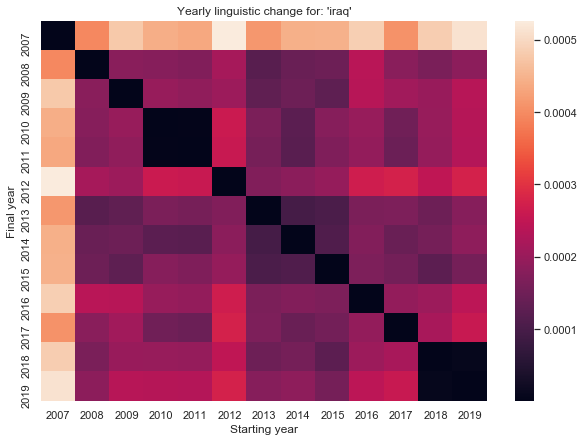

In [89]:
plot_divergence('iraq', data_comparedEmbeddings)

middle


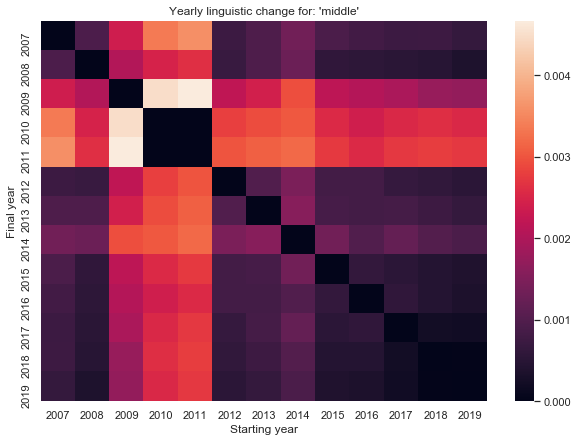

In [90]:
plot_divergence('middle', data_comparedEmbeddings)

east


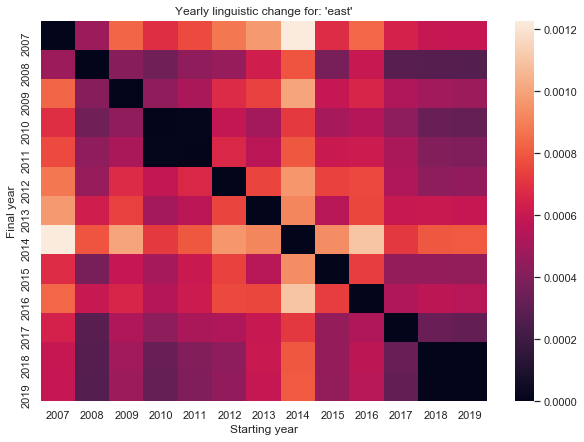

In [91]:
plot_divergence('east', data_comparedEmbeddings)

palestinian


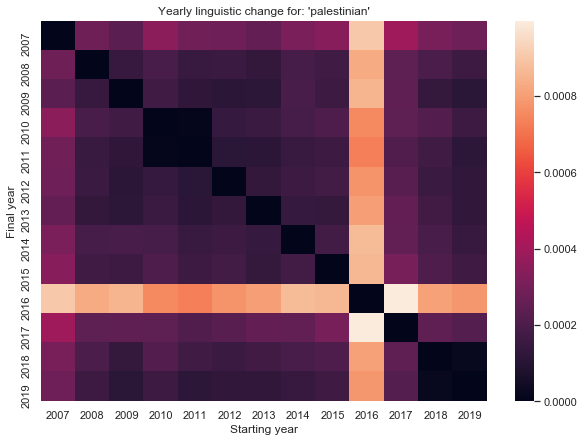

In [95]:
plot_divergence('palestinian', data_comparedEmbeddings)

refugee


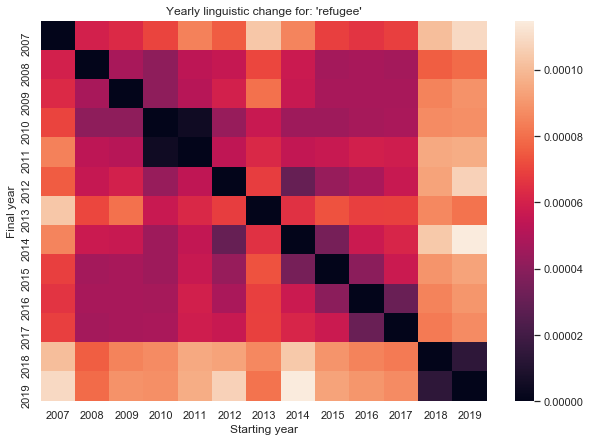

In [99]:
plot_divergence('refugee', data_comparedEmbeddings)

jewish


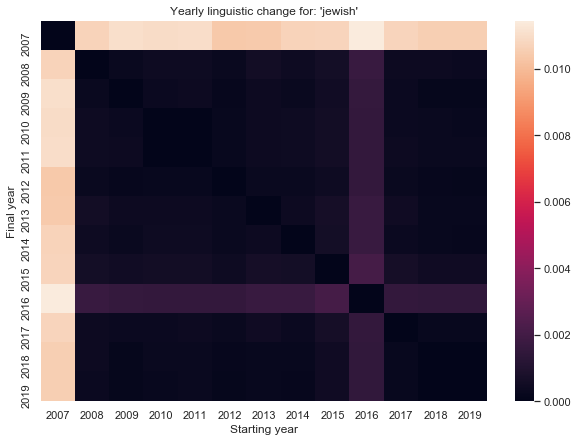

In [104]:
plot_divergence('jewish', data_comparedEmbeddings)

arab


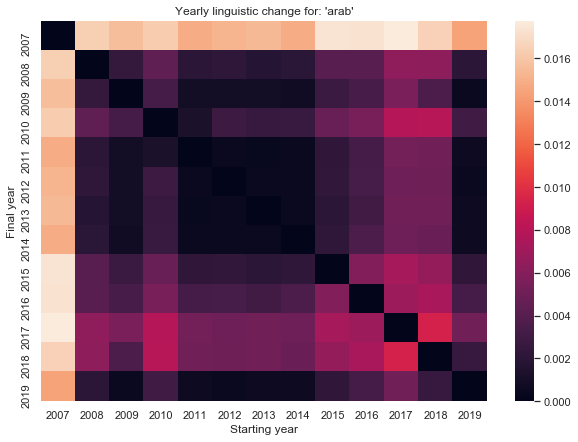

In [105]:
plot_divergence('arab', data_comparedEmbeddings)

afghanistan


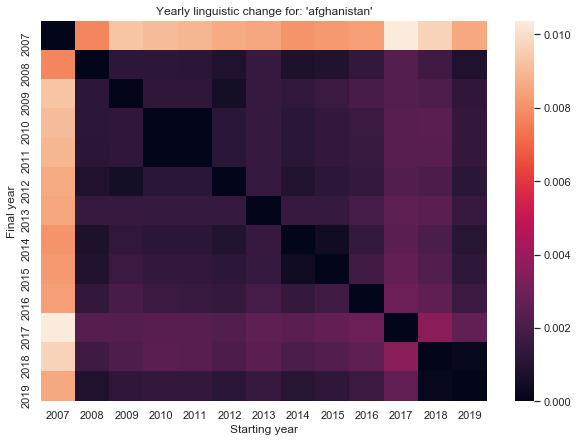

In [106]:
plot_divergence('afghanistan', data_comparedEmbeddings)

detain


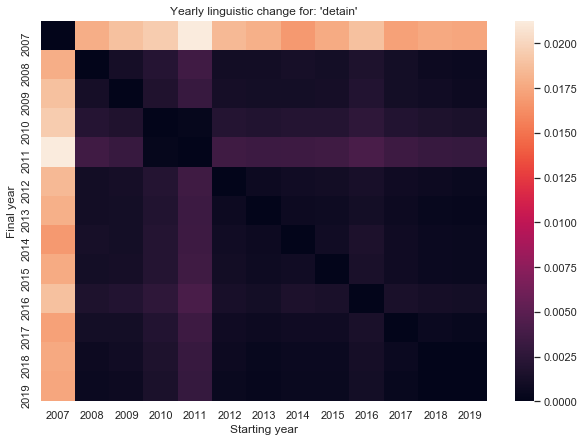

In [107]:
plot_divergence('detain', data_comparedEmbeddings)

money


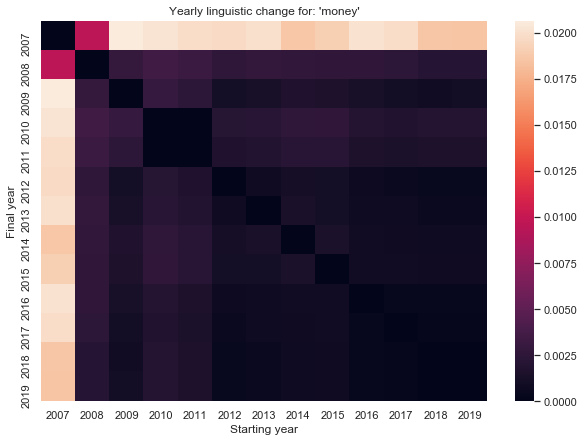

In [108]:
plot_divergence('money', data_comparedEmbeddings)

student


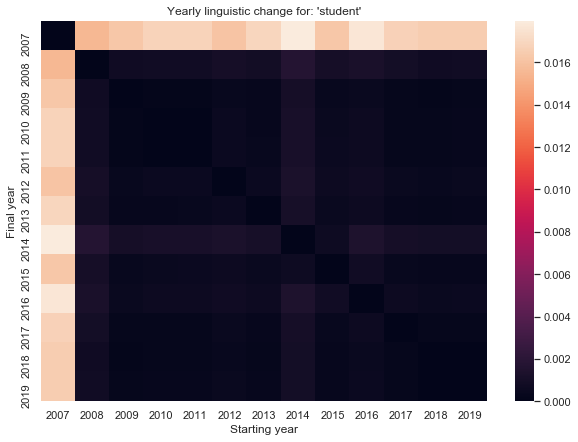

In [109]:
plot_divergence('student', data_comparedEmbeddings)